# Polynomial Regression


What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called Polynomial Regression.

There are two factors when determining model performance: overfitting and underfitting. Overfitting is when the model is too complex and does well on the training data but not on the test data. Underfitting is when the model is too simple and performs poorly on the training and testing data sets. 

Overfitting is simple to deal with, using methods like regularization, which we will discuss in the next lab. To deal with underfitting, we can build a more complex model using methods like polynomial regression. If making a more complex model does not work, this may involve using more data to train the model on or obtaining new features. As this process is complex, it's better to determine if the model can overfit the data first. Therefore, in this section, we will use Polynomial Regression to overfit the data to determine if we have an adequate amount of data.

In this notebook, we will explore Polynomial Regression and perform polynomial transform using individual features as well as multiple features.


## Objectives

After completing this lab you will be able to:

*   Understand the concept of  overfitting versus underfitting
*   Apply polynomial transforms to data 
*   Perform  hyperparameters grid search on a model, using validation data 

---

In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

The function below will calculate the $R^{2}$ on each feature given the a input model.


In [3]:
def get_R2_features(model,test=True): 
    #X: global  
    features=list(X)
    features.remove("three")
    
    R_2_train=[]
    R_2_test=[]

    for feature in features:
        model.fit(X_train[[feature]],y_train)
        
        R_2_test.append(model.score(X_test[[feature]],y_test))
        R_2_train.append(model.score(X_train[[feature]],y_train))
        
    plt.bar(features,R_2_train,label="Train")
    plt.bar(features,R_2_test,label="Test")
    plt.xticks(rotation=90)
    plt.ylabel("$R^2$")
    plt.legend()
    plt.show()
    print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
    print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )

The function below will plot the distribution of two inputs.


In [4]:
def  plot_dis(y,yhat):
    
    plt.figure()
    ax1 = sns.kdeplot(y, color="r", label="Actual Value")
    sns.kdeplot(yhat, color="b", label="Fitted Values" , ax=ax1)
    plt.legend()

    plt.title('Actual vs Fitted Values')
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

## **Reading and understanding our data**

For this lab, we will be using the car sales dataset, hosted on IBM Cloud object storage. This dataset can also be found and downloaded from [kaggle.com](https://www.kaggle.com/datasets/goyalshalini93/car-data), an open public data source.
The dataset contains all the information about cars, a name of a manufacturer, all car's technical parameters and a sale price of a car.

This dataset has already been pre-cleaned and encoded (using one-hot and label encoders) in the Linear Regression Notebook.

Let's read the data into *pandas* data frame and look at the first 5 rows using the `head()` method.


In [5]:
data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/encoded_car_data.csv')
data.head()

,diesel,gas,std,turbo,convertible,hardtop,hatchback,sedan,wagon,4wd,...,wheelbase,curbweight,enginesize,boreratio,horsepower,carlength,carwidth,citympg,highwaympg,price
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,13495.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,88.6,2548.0,130.0,3.47,111.0,168.8,64.1,21.0,27.0,16500.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,94.5,2823.0,152.0,2.68,154.0,171.2,65.5,19.0,26.0,16500.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,99.8,2337.0,109.0,3.19,102.0,176.6,66.2,24.0,30.0,13950.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,99.4,2824.0,136.0,3.19,115.0,176.6,66.4,18.0,22.0,17450.0


We can find more information about the features and types using the `info()`  method.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diesel       205 non-null    float64
 1   gas          205 non-null    float64
 2   std          205 non-null    float64
 3   turbo        205 non-null    float64
 4   convertible  205 non-null    float64
 5   hardtop      205 non-null    float64
 6   hatchback    205 non-null    float64
 7   sedan        205 non-null    float64
 8   wagon        205 non-null    float64
 9   4wd          205 non-null    float64
 10  fwd          205 non-null    float64
 11  rwd          205 non-null    float64
 12  dohc         205 non-null    float64
 13  dohcv        205 non-null    float64
 14  l            205 non-null    float64
 15  ohc          205 non-null    float64
 16  ohcf         205 non-null    float64
 17  ohcv         205 non-null    float64
 18  rotor        205 non-null    float64
 19  eight   

We have 35 features in our dataset after the one hot encoding. 

Before we begin our polynomial analysis, let's visualize some of the relationships between our features and the target variable, 'price'.

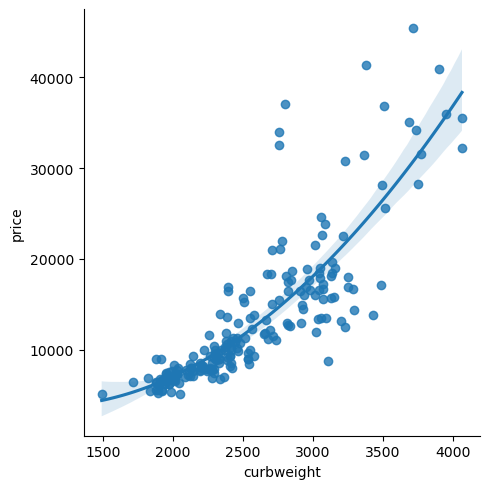

In [7]:
sns.lmplot(x = 'curbweight', y = 'price', data = data, order=2)
plt.show()

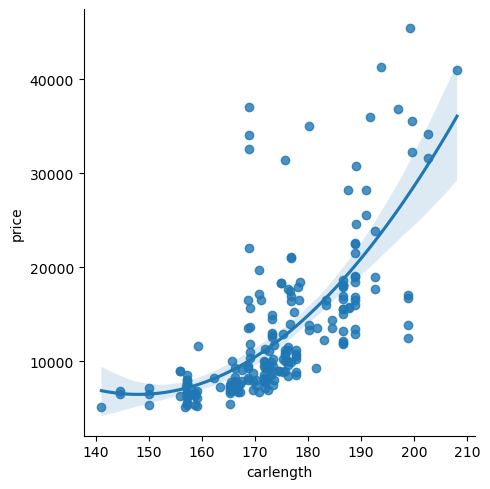

In [8]:
sns.lmplot(x = 'carlength', y = 'price', data = data, order=2)
plt.show()

The relationship is more curved.


## Data Preparation

Let's first split our data into ```X``` features and ```y``` target.


In [9]:
X = data.drop('price', axis=1)
y = data.price

## Train Test Split 

Now, we split our data, using <code>train_test_split</code> function, into the training and testing sets, allocating 30% of the data for testing.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print("Number of test samples:", X_test.shape[0])
print("Number of training samples:", X_train.shape[0])

Number of test samples: 62
Number of training samples: 143


### Multiple Features

Let's create a <code>LinearRegression</code> object, called `lm`. 


In [11]:
lm = LinearRegression()

Now, let's fit the model with multiple features on our X_train and y_train data.


In [12]:
lm.fit(X_train, y_train)

LinearRegression()

We apply `predict()` function on the testing data set.


In [13]:
predicted = lm.predict(X_test)

Let's calculate the `r2_score()` on both, training and testing data sets.


In [14]:
print("R^2 on training  data ",lm.score(X_train, y_train))
print("R^2 on testing data ",lm.score(X_test,y_test))

R^2 on training  data  0.9261971276889319
R^2 on testing data  0.8480039754607426


We can plot distributions of the predicted values versus the actual values. 


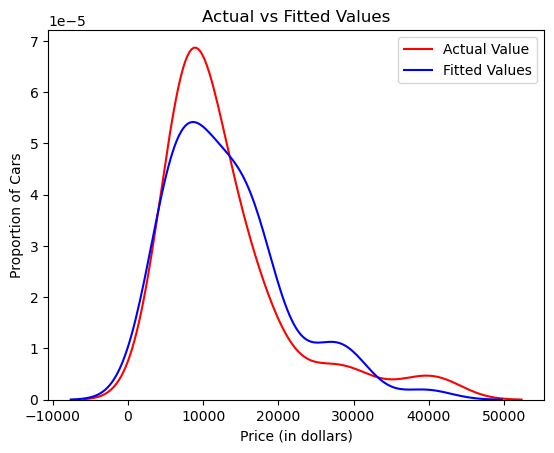

In [15]:
plot_dis(y_test,predicted)

Below, we will view the estimated coefficients for the linear regression problem.


In [16]:
{col:coef for col,coef in zip(X.columns, lm.coef_)}

{'diesel': 829636766984151.1,
 'gas': 829636766982663.5,
 'std': 308.79322869962664,
 'turbo': -312.816114190806,
 'convertible': 1747.3355791736878,
 'hardtop': 3131.047522300332,
 'hatchback': -1763.7445862840839,
 'sedan': -656.3559812799834,
 'wagon': -2456.206826307067,
 '4wd': -598.2379648797238,
 'fwd': -332.6222811892858,
 'rwd': 930.7669313923465,
 'dohc': 2434.7241527908236,
 'dohcv': -13154.976443800606,
 'l': 2087.083189167487,
 'ohc': 4608.018083123116,
 'ohcf': 6035.209987039361,
 'ohcv': -2808.012508549575,
 'rotor': 798.1705520193302,
 'eight': 9153.568956242889,
 'five': -2789.001856358008,
 'four': -5306.07508049013,
 'six': -2133.560350537515,
 'three': 0.0009765625,
 'twelve': 276.96957159943406,
 'two': 798.1234481374943,
 'wheelbase': 104.43805715061161,
 'curbweight': 4.677615249520538,
 'enginesize': 23.385334181438758,
 'boreratio': -1785.2419210822043,
 'horsepower': 68.50703952711588,
 'carlength': -64.40719788177243,
 'carwidth': 580.1302958999373,
 'citympg

As we see, the first two coefficients are too large to plot, so we'll drop them and plot the rest of the coefficients.


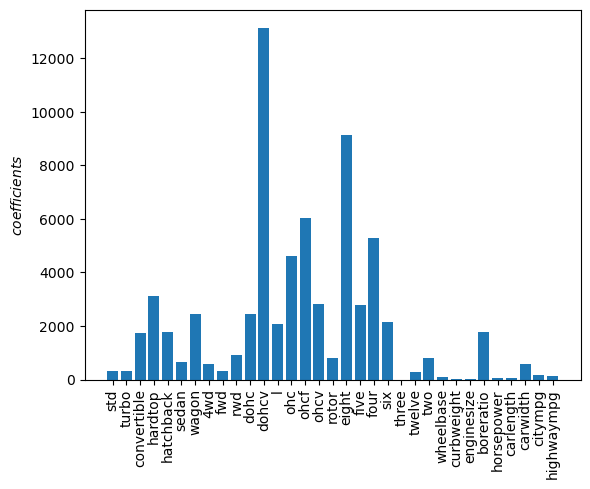

In [17]:
plt.bar(X.columns[2:],abs(lm.coef_[2:]))
plt.xticks(rotation=90)
plt.ylabel("$coefficients$")
plt.show()

Usually, we can interpret the lager coefficients as having more importance on the prediction, but this is not always the case, so let's look at the individual features. 


### Individual Features 

We can train the model and plot our $R^2$ for each of the features on the training and testing data sets, using the function <code>get_R2_features</code>.

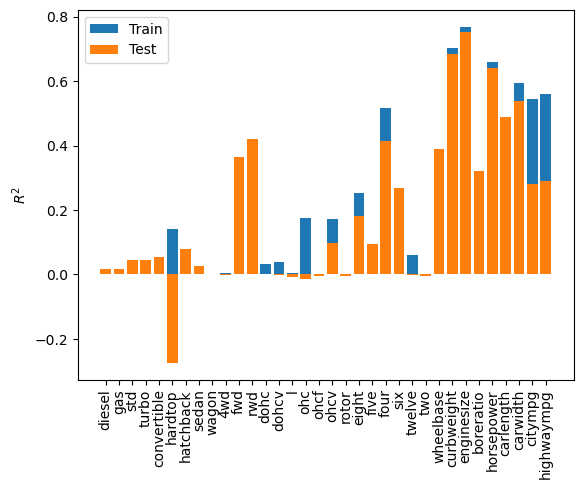

Training R^2 mean value 0.21817773426877915 Testing R^2 mean value 0.18241493035139267 
Training R^2 max value 0.7686929078033781 Testing R^2 max value 0.7534902447506853 


In [18]:
get_R2_features(lm)

From the above plot, we see that some individual features perform similarly to  using all the features (we removed the feature ```three``` ), in  addition, we see that smaller coefficients seem to correspond to a larger $R^{2}$, therefore  larger coefficients correspond to overfiting.


Usando `pipeline()`

In [19]:
pipe = Pipeline([('ss',StandardScaler() ),
                 ('lr', LinearRegression())])

pipe.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('lr', LinearRegression())])

In [20]:
print("R^2 on training  data ", pipe.score(X_train, y_train))
print("R^2 on testing data ", pipe.score(X_test,y_test))

R^2 on training  data  0.9262722224294516
R^2 on testing data  0.8419174509630336


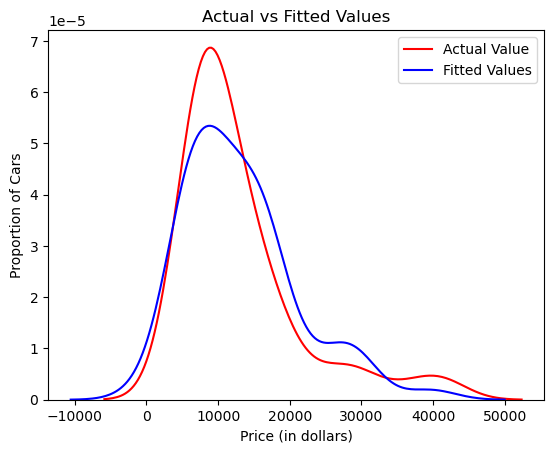

In [21]:
predicted = pipe.predict(X_test)
plot_dis(y_test,predicted)
plt.show()

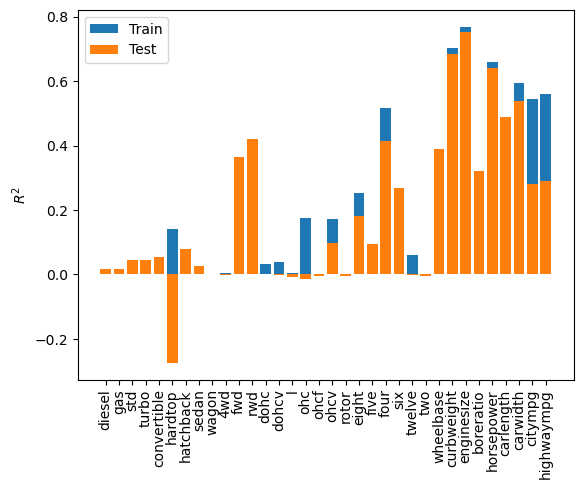

Training R^2 mean value 0.21817773426877915 Testing R^2 mean value 0.18241493035139264 
Training R^2 max value 0.7686929078033782 Testing R^2 max value 0.7534902447506853 


In [22]:
get_R2_features(pipe)

## Polynomial Features

### Multiple Features

Polynomial transform is a simple way to increase the complexity of the model, but we must be mindful of overfilling.
Below, we will perform a second degree (degree=2) polynomial transformation.

In [23]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

Now, we transform the training and testing data sets.


In [24]:
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

`X_train_poly` and `X_test_poly` now contain the original features of X plus the square of these features and the cross-terms combination.
Let's check the shape of the newly created train and test sets.


In [26]:
print(X_train_poly.shape)
print(X_test_poly.shape)


(143, 665)
(62, 665)


In [27]:
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

LinearRegression()

And we make predictions.


In [28]:
predicted = lm.predict(X_train_poly)

Again, we can ckeck the `r2_score()` on both, training and testing data sets.


In [29]:
print("R^2 on training data:", lm.score(X_train_poly, y_train))
print("R^2 on testing data:", lm.score(X_test_poly,y_test))

R^2 on training data: 0.9985318497975858
R^2 on testing data: -36729.95849573239


We see the model has a negative $R^{2}$ on the test data set, this is sign of overfiting.


### Individual Features 

<p>Data Pipelines simplify the steps of processing the data. We use the module <code>Pipeline</code> to create a pipeline. We also use <code>PolynomialFeatures</code> as a step in our pipeline.</p>



In [30]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)),
        ('model', LinearRegression())]

We can repeat the steps above, using the <code>Pipleine</code> object.


In [31]:
pipe=Pipeline(Input)
pipe.fit(X_train, y_train)

Pipeline(steps=[('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

We can see the results are identical.


In [32]:
print("R^2 on training  data:", pipe.score(X_train, y_train))
print("R^2 on testing data:", pipe.score(X_test,y_test))

R^2 on training  data: 0.9985318497975858
R^2 on testing data: -36729.95849573239


We can train our model on each of the features using the Polynomial Feature transform of the second degree. Then we can plot our $R^2$. 


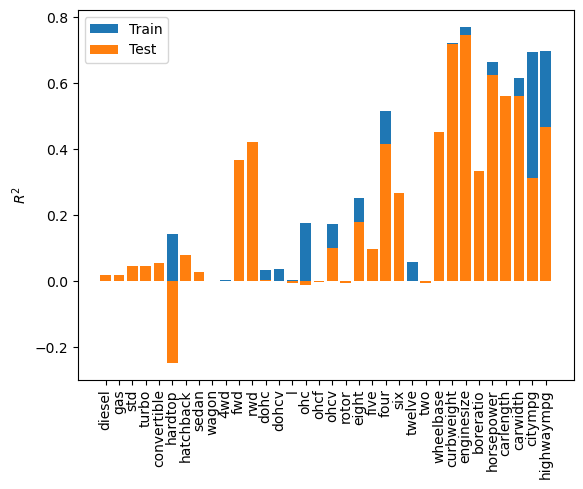

Training R^2 mean value 0.2307636543674421 Testing R^2 mean value 0.1947009453004004 
Training R^2 max value 0.7706959974452947 Testing R^2 max value 0.7463370080614307 


In [33]:
get_R2_features(pipe)

Feature with the max $R^{2}$ is higher than when using all the features.


## GridSearch and  Pipeline

In this section of the notebook, we will define a pipeline object, then use GridSearch to find the best hyper-parameters of the model by using  cross-validation method of the  parameter grid, as shown in the figure below. A 5-fold cross validation is used by default. We will learn more about k-fold cross validation in the next, Cross Validation lesson of the Course.

We create `PolynomialFeatures()` pipeline.


In [34]:
Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), 
       ('model',LinearRegression())]
pipe=Pipeline(Input)

To search for the best combination of hyperparameters, we create a  <b>GridSearchCV</b> object with dictionary of parameter values. The parameters of pipelines can be set using the name of the key separated by 
'__', then the parameter name of the key.

In [35]:
param_grid = {
    'polynomial__degree': [1, 2, 3, 4]
}

<b>polynomial__degree</b>: is the degree of the polynomial. 

<b>model__normalize</b> This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm.


In [36]:
search = GridSearchCV(pipe, param_grid, n_jobs=1) 

In [37]:
search.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(include_bias=False)),
                                       ('model', LinearRegression())]),
             n_jobs=1, param_grid={'polynomial__degree': [1, 2, 3, 4]})

The object finds the best parameter values on the validation data. We can obtain the estimator with the best parameters and assign it to the variable `best`, as follows:


In [39]:
search.best_params_

{'polynomial__degree': 1}

In [42]:
search.score(X_test, y_test)


0.8480871443956641

In [43]:
predicted = search.predict(X_test)

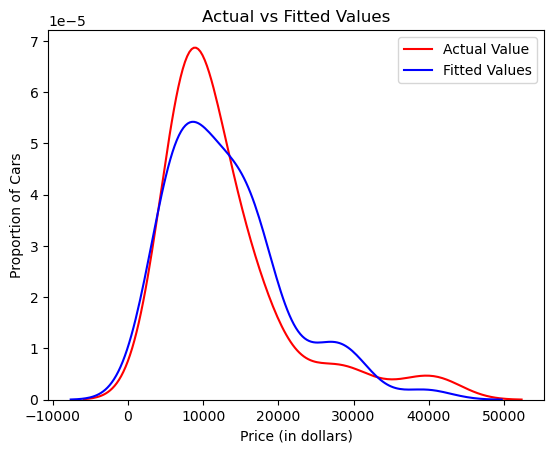

In [44]:
plot_dis(y_test,predicted)

diesel
gas
std
turbo
convertible
hardtop
hatchback
sedan
wagon
4wd
fwd
rwd
dohc
dohcv
l
ohc
ohcf
ohcv
rotor
eight
five
four
six
three
twelve
two
wheelbase
curbweight
enginesize
boreratio
horsepower
carlength
carwidth
citympg
highwaympg


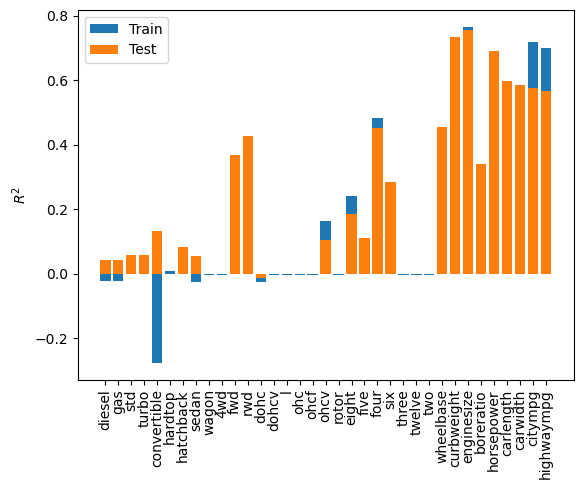

Training R^2 mean value 0.18271466517849122 Testing R^2 mean value 0.2198096266148385 
Training R^2 max value 0.7653236373791239 Testing R^2 max value 0.7565151400968062 


In [45]:
# Enter your code and run the cell
features=list(X)
   
    
R_2_train=[]
R_2_test=[]

for feature in features:
    param_grid = {
    "polynomial__degree": [ 1, 2,3,4,5],
    #'model__positive': [LinearRegression(), 'passthrough']
    "model__positive":[True, False]
    }
    Input=[ ('polynomial', PolynomialFeatures(include_bias=False,degree=2)), ('model',LinearRegression())]
    pipe=Pipeline(Input)
    print(feature)
    search = GridSearchCV(pipe, param_grid, n_jobs=2)
    search.fit(X_test[[feature]], y_test)
    best=search.best_estimator_
        
    R_2_test.append(best.score(X_test[[feature]],y_test))
    R_2_train.append(best.score(X_train[[feature]],y_train))
    
        
plt.bar(features,R_2_train,label="Train")
plt.bar(features,R_2_test,label="Test")
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.legend()
plt.show()
print("Training R^2 mean value {} Testing R^2 mean value {} ".format(str(np.mean(R_2_train)),str(np.mean(R_2_test))) )
print("Training R^2 max value {} Testing R^2 max value {} ".format(str(np.max(R_2_train)),str(np.max(R_2_test))) )